### Test Toy for Task 3

In [ ]:
TEST_WITH_REF = False # NOTE: toggle this flag to `True` to enable testing with running the cells with ref
# TEST_WITH_REF = True

In [ ]:
# device = "cpu" # NOTE: you had better use "cuda", otherwise it might be very slow
device = "cuda:0"
device_ref = "cuda:1" # NOTE: you had better put ref training codes into another GPU if available, otherwise it might easily run out of memory

In [3]:
model_dir = "./model/llama_3.2_1b_instruct/"
num_shards = 1

#### Step0. set up the environment

In [47]:
import os
import json
from datetime import datetime

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.testing import assert_close

from transformers import LlamaForCausalLM, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [5]:
if TEST_WITH_REF:
    from ref.modeling import (
        BatchLayout as BatchLayoutRef,
        PaddingSide as PaddingSideRef,
        TruncateSide as TruncateSideRef,
        
        PromptTemplate as PromptTemplateRef,
    )
    from ref.modeling.models import (
        LlamaConfig as LlamaConfigRef,
        LlamaTokenizer as LlamaTokenizerRef,
        LlamaModel as LlamaModelRef,
    )
    from ref.modeling.datasets import (
        BaseDatasetConfig as BaseDatasetConfigRef,
        QADatasetConfig as QADatasetConfigRef,
        QADataset as QADatasetRef,
        ChatDatasetConfig as ChatDatasetConfigRef,
        ChatDataset as ChatDatasetRef,
    )
    from ref.training import (
        OptimizerType as OptimizerTypeRef,
        TrainLogType as TrainLogTypeRef,
        BaseTrainConfig as BaseTrainConfigRef,
        BaseTrainer as BaseTrainerRef,
        LoRATrainConfig as LoRATrainConfigRef,
        LoRATrainer as LoRATrainerRef,
    )

In [6]:
from src.modeling import (
    BatchLayout,
    PaddingSide,
    TruncateSide,
    
    PromptTemplate,
)
from src.modeling.models import (
    BaseTokenizer,
    BaseModel,
    LlamaConfig,
    LlamaTokenizer,
    LlamaModel,
)
from src.modeling.datasets import (
    BaseDatasetConfig,
    QADatasetConfig,
    QADataset,
    ChatDatasetConfig,
    ChatDataset,
)
from src.training import (
    OptimizerType,
    TrainLogType,
    BaseTrainConfig,
    BaseTrainer,
    LoRATrainConfig,
    LoRATrainer,
)

#### Step1. load the pretrained tokenizer

In [7]:
tokenizer_file = os.path.join(model_dir, "tokenizer.json")
tokenizer_config_file = os.path.join(model_dir, "tokenizer_config.json")

In [8]:
if TEST_WITH_REF:
    llama_tokenizer_ref = LlamaTokenizerRef(
        vocab_file=tokenizer_file,
        config_file=tokenizer_config_file,
    )
    print(llama_tokenizer_ref)

In [9]:
llama_tokenizer = LlamaTokenizer(
    vocab_file=tokenizer_file,
    config_file=tokenizer_config_file,
)
llama_tokenizer

LlamaTokenizer()

#### Step2. build the QADataset

In [10]:
qa_train_data_file = "./data/qa/qa_train.jsonl"
qa_eval_data_file = "./data/qa/qa_eval.jsonl"
qa_test_data_file = "./data/qa/qa_test.jsonl"

In [ ]:
if TEST_WITH_REF:
    qa_dataset_config_ref = QADatasetConfigRef(
        batch_size=2,
        seq_len=512,
        drop_last_incomplete_batch=True,
        padding_side=PaddingSideRef.LEFT,
        truncate_side=TruncateSideRef.RIGHT,
        device=device_ref,
    )
    print(qa_dataset_config_ref)

In [12]:
qa_dataset_config = QADatasetConfig(
    batch_size=2,
    seq_len=512,
    drop_last_incomplete_batch=True,
    padding_side=PaddingSide.LEFT,
    truncate_side=TruncateSide.RIGHT,
    device=device,
)
qa_dataset_config

********************   QADatasetConfig   ********************
answer_key: 'answer'
answer_prefix: 'ANSWER'
batch_layout: BatchLayout.STACK
batch_size: 2
cu_seqlens_key: 'cu_seqlens'
device: 'cuda'
drop_last_incomplete_batch: True
ignore_idx: -100
input_ids_key: 'input_ids'
labels_key: 'labels'
padding_side: PaddingSide.LEFT
prefix_template: PromptTemplate()
question_key: 'question'
question_prefix: 'QUESTION'
samples_key: 'samples'
sep_str: '\n'
seq_len: 512
truncate_side: TruncateSide.RIGHT
*************************************************************

In [13]:
if TEST_WITH_REF:
    qa_train_dataset_ref = QADatasetRef(
        config=qa_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=qa_train_data_file,
    )
    qa_eval_dataset_ref = QADatasetRef(
        config=qa_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=qa_eval_data_file,
    )
    qa_test_dataset_ref = QADatasetRef(
        config=qa_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=qa_test_data_file,
    )

    print(qa_train_dataset_ref.num_samples(), qa_train_dataset_ref.num_batchs(), qa_eval_dataset_ref.num_samples(), qa_eval_dataset_ref.num_batchs(), qa_test_dataset_ref.num_samples(), qa_test_dataset_ref.num_batchs())

In [14]:
qa_train_dataset = QADataset(
    config=qa_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=qa_train_data_file,
)
qa_eval_dataset = QADataset(
    config=qa_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=qa_eval_data_file,
)
qa_test_dataset = QADataset(
    config=qa_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=qa_test_data_file,
)

qa_train_dataset.num_samples(), qa_train_dataset.num_batchs(), qa_eval_dataset.num_samples(), qa_eval_dataset.num_batchs(), qa_test_dataset.num_samples(), qa_test_dataset.num_batchs()

(9800, 4900, 200, 100, 300, 150)

In [15]:
if TEST_WITH_REF:
    sample_ref = qa_test_dataset_ref.sample(200)
    print(sample_ref)
    
    batch_ref = qa_test_dataset_ref.batch(100)
    
    print(batch_ref[qa_dataset_config_ref.samples_key])

    print(batch_ref[qa_dataset_config_ref.input_ids_key], batch_ref[qa_dataset_config_ref.input_ids_key].shape)

    print(batch_ref[qa_dataset_config_ref.labels_key], batch_ref[qa_dataset_config_ref.labels_key].shape)

    print(llama_tokenizer_ref.decode(batch_ref[qa_dataset_config_ref.input_ids_key][0]))

    labels_ref = batch_ref[qa_dataset_config_ref.labels_key][0].clone()
    labels_ref[labels_ref == qa_dataset_config_ref.ignore_idx] = llama_tokenizer_ref.bos_id \
        if qa_dataset_config_ref.padding_side == PaddingSideRef.LEFT else llama_tokenizer_ref.eos_id
    print(llama_tokenizer_ref.decode(labels_ref))

In [16]:
sample = qa_test_dataset.sample(200)
print(sample)

batch = qa_test_dataset.batch(100)

print(batch[qa_dataset_config.samples_key])

print(batch[qa_dataset_config.input_ids_key], batch[qa_dataset_config.input_ids_key].shape)

print(batch[qa_dataset_config.labels_key], batch[qa_dataset_config.labels_key].shape)

print(llama_tokenizer.decode(batch[qa_dataset_config.input_ids_key][0]))

labels = batch[qa_dataset_config.labels_key][0].clone()
labels[labels == qa_dataset_config.ignore_idx] = llama_tokenizer.bos_id \
    if qa_dataset_config.padding_side == PaddingSide.LEFT else llama_tokenizer.eos_id
llama_tokenizer.decode(labels)

{'question': 'Generate a detailed description that thoroughly compares and contrasts two notable works of abstract art in terms of their composition, use of line, space, shape, form, color, and overall intended meaning or theme conveyed. Refer to specific elements within both pieces to support your analysis of their similarities and differences. Make sure to cite the titles of the works, name their artists, and provide the year and location where each piece was created.', 'answer': 'Both Kandinsky\'s Composition VIII, created in Munich in 1923, and Mondrian\'s Composition with Yellow, Blue and Red, created in New York City during 1937-1942, use a reduction of natural forms to geometric shapes, lines and planes of primary colors. However, there are key differences in their compositional structure, use of line and sense of space.\n\nIn terms of composition, Kandinsky\'s piece is more dynamic, with curved lines and irregular shapes that overlap one another, conveying a sense of motion and

['Both Kandinsky\'s Composition VIII, created in Munich in 1923, and Mondrian\'s Composition with Yellow, Blue and Red, created in New York City during 1937-1942, use a reduction of natural forms to geometric shapes, lines and planes of primary colors. However, there are key differences in their compositional structure, use of line and sense of space.\n\nIn terms of composition, Kandinsky\'s piece is more dynamic, with curved lines and irregular shapes that overlap one another, conveying a sense of motion and interaction. Mondrian\'s composition consists of perfect vertical and horizontal black lines that divide the canvas into segregated rectangular planes filled with primary colors, creating a static, calm and orderly visual field.  \n\nKandinsky employs curved lines throughout his work, bending and looping through undulating forms to create an overall rhythmic cadence that suggests activity and flow. The curved lines correspond with oval and circular shapes. By contrast, Mondrian us

#### Step3. build the ChatDataset

In [17]:
chat_test_data_file = "./data/chat/chat_test.jsonl"
chat_train_data_file = "./data/chat/chat_train.jsonl"
chat_eval_data_file = "./data/chat/chat_eval.jsonl"

In [ ]:
if TEST_WITH_REF:
    chat_dataset_config_ref = ChatDatasetConfigRef(
        batch_size=2,
        seq_len=1024,
        drop_last_incomplete_batch=True,
        padding_side=PaddingSideRef.LEFT,
        truncate_side=TruncateSideRef.RIGHT,
        device=device_ref,
    )
    print(chat_dataset_config_ref)

In [19]:
chat_dataset_config = ChatDatasetConfig(
    batch_size=2,
    seq_len=1024,
    drop_last_incomplete_batch=True,
    padding_side=PaddingSide.LEFT,
    truncate_side=TruncateSide.RIGHT,
    device=device,
)
chat_dataset_config

********************   ChatDatasetConfig   ********************
batch_layout: BatchLayout.STACK
batch_size: 2
bot_role_prefix: 'CHATBOT'
bot_role_value: 'chatbot'
content_key: 'content'
conversations_key: 'conversations'
cu_seqlens_key: 'cu_seqlens'
device: 'cuda'
drop_last_incomplete_batch: True
ignore_idx: -100
input_ids_key: 'input_ids'
labels_key: 'labels'
padding_side: PaddingSide.LEFT
prefix_template: PromptTemplate()
role_key: 'role'
samples_key: 'samples'
sep_str: '\n'
seq_len: 1024
truncate_side: TruncateSide.RIGHT
user_role_prefix: 'USER'
user_role_value: 'user'
***************************************************************

In [20]:
if TEST_WITH_REF:
    chat_train_dataset_ref = ChatDatasetRef(
        config=chat_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=chat_train_data_file,
    )
    chat_eval_dataset_ref = ChatDatasetRef(
        config=chat_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=chat_eval_data_file,
    )
    chat_test_dataset_ref = ChatDatasetRef(
        config=chat_dataset_config_ref,
        tokenizer=llama_tokenizer_ref,
        data_files=chat_test_data_file,
    )

    print(chat_train_dataset_ref.num_samples(), chat_train_dataset_ref.num_batchs(), chat_eval_dataset_ref.num_samples(), chat_eval_dataset_ref.num_batchs(), chat_test_dataset_ref.num_samples(), chat_test_dataset_ref.num_batchs())

In [21]:
chat_train_dataset = ChatDataset(
    config=chat_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=chat_train_data_file,
)
chat_eval_dataset = ChatDataset(
    config=chat_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=chat_eval_data_file,
)
chat_test_dataset = ChatDataset(
    config=chat_dataset_config,
    tokenizer=llama_tokenizer,
    data_files=chat_test_data_file,
)

chat_train_dataset.num_samples(), chat_train_dataset.num_batchs(), chat_eval_dataset.num_samples(), chat_eval_dataset.num_batchs(), chat_test_dataset.num_samples(), chat_test_dataset.num_batchs()

(9800, 4900, 200, 100, 500, 250)

In [22]:
if TEST_WITH_REF:
    sample_ref = chat_test_dataset_ref.sample(200)
    print(sample_ref)
    
    batch_ref = chat_test_dataset_ref.batch(100)
    
    print(batch_ref[chat_dataset_config_ref.samples_key])

    print(batch_ref[chat_dataset_config_ref.input_ids_key], batch_ref[chat_dataset_config_ref.input_ids_key].shape)

    print(batch_ref[chat_dataset_config_ref.labels_key], batch_ref[chat_dataset_config_ref.labels_key].shape)

    print(llama_tokenizer_ref.decode(batch_ref[chat_dataset_config_ref.input_ids_key][0]))

    labels_ref = batch_ref[chat_dataset_config_ref.labels_key][0].clone()
    labels_ref[labels_ref == chat_dataset_config_ref.ignore_idx] = llama_tokenizer_ref.bos_id \
        if chat_dataset_config_ref.padding_side == PaddingSideRef.LEFT else llama_tokenizer_ref.eos_id
    print(llama_tokenizer_ref.decode(labels_ref))

In [23]:
sample = chat_test_dataset.sample(200)
print(sample)

batch = chat_test_dataset.batch(100)

print(batch[chat_dataset_config.samples_key])

print(batch[chat_dataset_config.input_ids_key], batch[chat_dataset_config.input_ids_key].shape)

print(batch[chat_dataset_config.labels_key], batch[chat_dataset_config.labels_key].shape)

print(llama_tokenizer.decode(batch[chat_dataset_config.input_ids_key][0]))

labels = batch[chat_dataset_config.labels_key][0].clone()
labels[labels == chat_dataset_config.ignore_idx] = llama_tokenizer.bos_id \
    if chat_dataset_config.padding_side == PaddingSide.LEFT else llama_tokenizer.eos_id
llama_tokenizer.decode(labels)

{'conversations': [{'role': 'user', 'content': 'Develop an algorithm to generate a random password that meets the following requirements: \n\n• At least 12 characters long   \n• Includes at least one uppercase letter     \n• Includes at least one lowercase letter\n• Includes at least one digit \n• Includes at least one special character\n\nProvide pseudocode or  Python code to generate the random password. Consider using string manipulation methods and the random library.'}, {'role': 'chatbot', 'content': '1. Import the random library  \n2. Define 4 lists:  upper_case, lower_case, digits and special_characters\n3. Populate the lists with relevant character sets \n4. Initialize an empty password string \n5. While the password length is less than 12:\n  - Select a random character from one of the 4 lists\n  - Append the character to the password string\n6. Check if the password contains at least one character from each list: \n  - If not, append a valid character from the missing list(s)

['1. Import the random library  \n2. Define 4 lists:  upper_case, lower_case, digits and special_characters\n3. Populate the lists with relevant character sets \n4. Initialize an empty password string \n5. While the password length is less than 12:\n  - Select a random character from one of the 4 lists\n  - Append the character to the password string\n6. Check if the password contains at least one character from each list: \n  - If not, append a valid character from the missing list(s) until all requirements are met\n7. Return the final password string  \n\nStep-by-step, this algorithm first defines the character sets needed, then iteratively builds up the password string by randomly selecting a character from one of those sets. It continues appending random characters until the password reaches at least 12 characters in length. Finally, it checks if all requirements have been fulfilled, and appends any missing character types to ensure a valid password is generated. This approach allo

#### Step4. build the LoRATrainConfig for QA task

In [24]:
save_ckpt_dir_qa = "./ckpt/lora_qa/"
load_ckpt_dirs_qa = None # NOTE: from scratch

In [ ]:
if TEST_WITH_REF:
    qa_train_config_ref = LoRATrainConfigRef(
        train_steps=10,
        eval_interval=2,
        eval_steps=1,
        
        shuffle=True,
        shuffle_seed=42,
        optimizer_type=OptimizerTypeRef.ADAMW,
        learning_rate=2e-4,
        
        load_ckpt_dirs=load_ckpt_dirs_qa,
        save_interval=4,
        save_ckpt_dir=save_ckpt_dir_qa,
        max_shard_size=1024, # MB
        save_only_lora=True,
        
        log_interval=1,
        log_types=(TrainLogTypeRef.TERMINAL,),
        # log_types=(TrainLogTypeRef.TERMINAL, TrainLogTypeRef.TENSORBOARD, TrainLogTypeRef.WANDB),
        log_kwargs={
            "wandb_api_key": "", # NOTE: replace this to your own wandb api key
            "wandb_project": "nju-llm-course", # NOTE: replace this to your own wandb project name
            "wandb_name": f"lora_qa_ref_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", # NOTE: replace this to your own wandb job name
            "wandb_dir": "./wandb/lora_qa_ref", # NOTE: replace this to your own wandb local dir
            
            "tensorboard_log_dir": "./tensorboard/lora_qa_ref", # NOTE: replace this to your own tensorboard local log dir
        },
        
        device=device_ref,
        
        lora_weight_A_pattern="lora_weight_A",
        lora_weight_B_pattern="lora_weight_B",
    )
    print(qa_train_config_ref)

In [26]:
qa_train_config = LoRATrainConfig(
    train_steps=10,
    eval_interval=2,
    eval_steps=1,
    
    shuffle=True,
    shuffle_seed=42,
    optimizer_type=OptimizerType.ADAMW,
    learning_rate=2e-4,
    
    load_ckpt_dirs=load_ckpt_dirs_qa,
    save_interval=4,
    save_ckpt_dir=save_ckpt_dir_qa,
    max_shard_size=1024, # MB
    save_only_lora=True,
    
    log_interval=1,
    log_types=(TrainLogType.TERMINAL,),
    # log_types=(TrainLogType.TERMINAL, TrainLogType.TENSORBOARD, TrainLogType.WANDB), # NOTE: to use multiple loggers if you've supported
    log_kwargs={
        "wandb_api_key": "", # NOTE: replace this to your own wandb api key
        "wandb_project": "nju-llm-course", # NOTE: replace this to your own wandb project name
        "wandb_name": f"lora_qa_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", # NOTE: replace this to your own wandb job name
        "wandb_dir": "./wandb/lora_qa", # NOTE: replace this to your own wandb local dir
        
        "tensorboard_log_dir": "./tensorboard/lora_qa", # NOTE: replace this to your own tensorboard local log dir
    },
    
    device=device,
    
    lora_weight_A_pattern="lora_weight_A", # NOTE: replace this to your own pattern
    lora_weight_B_pattern="lora_weight_B", # NOTE: replace this to your own pattern
)
qa_train_config

********************   LoRATrainConfig   ********************
betas: (0.9, 0.999)
ckpt_file_ext: 'safetensors'
ckpt_step_prefix: 'step-'
device: 'cuda'
eval_interval: 2
eval_steps: 1
learning_rate: 0.0002
load_ckpt_dirs: None
load_ckpt_step: True
log_interval: 1
log_kwargs: {'wandb_api_key': '', 'wandb_project': 'nju-llm-course', 'wandb_name': 'lora_qa_2024-12-02 21:11:49', 'wandb_dir': './wandb/lora_qa', 'tensorboard_log_dir': './tensorboard/lora_qa'}
log_last_step: True
log_types: (<TrainLogType.TERMINAL: 'terminal'>,)
lora_weight_A_pattern: 'lora_weight_A'
lora_weight_B_pattern: 'lora_weight_B'
max_shard_size: 1024
momentum: 0.0
optimizer_type: OptimizerType.ADAMW
save_ckpt_dir: './ckpt/lora_qa/'
save_interval: 4
save_last_step: True
save_only_lora: True
shuffle: True
shuffle_seed: 42
step_idx_width: 5
train_steps: 10
weight_decay: 0.0
*************************************************************

#### Step5. build the LoRATrainer to finetune the model on QA task

In [27]:
punit, munit = "M", "MB"
lora_rank_qa = 8

In [28]:
config_file = os.path.join(model_dir, "config.json")
params_files = os.path.join(model_dir, "model.safetensors")

with open(config_file, "r") as f:
    config = json.load(f)

In [ ]:
llama_model_qa_ref = None
if TEST_WITH_REF:
    llama_config_qa_ref: LlamaConfigRef = LlamaModelRef.load_config(
        config_file,
        lora_rank=lora_rank_qa,
        param_device=device_ref,
    )
    print(llama_config_qa_ref)
    
    llama_model_qa_ref = LlamaModelRef(llama_config_qa_ref)
    llama_model_qa_ref.load_parameters(params_files)
llama_model_qa_ref

In [30]:
llama_config_qa: LlamaConfig = LlamaModel.load_config(
    config_file,
    lora_rank=lora_rank_qa,
    param_device=device,
)
print(llama_config_qa)

llama_model_qa = LlamaModel(llama_config_qa)
llama_model_qa.load_parameters(params_files)

********************   LlamaConfig   ********************
activation_type: MLPActivationType.SILU
apply_qk_norm: False
causal: True
eps: 1e-05
ffh_size: 8192
gate_init_mean: 0.0
gate_init_std: 1.0
group_size: None
head_dim: 64
hidden_size: 2048
init_base_seed: 42
lm_head_tied: True
lora_alpha: None
lora_dropout_rate: 0.0
lora_dropout_seed: 42
lora_init_base_seed: 42
lora_rank: 8
max_seq_len: 8192
moe_topk: 1
norm_init_range: (-1.0, 1.0)
num_experts: None
num_kv_head: 8
num_layers: 16
num_q_head: 32
online_attn_block_size: None
param_device: 'cuda'
param_dtype: torch.bfloat16
process_group: None
proj_init_mean: 0.0
proj_init_seed: 42
proj_init_std: 1.0
qk_norm_group_size: None
qkv_layout: AttnQKVLayout.BSHD
qkv_pack_format: AttnQKVPackFormat.Q_K_V
rank: 0
rope_base: 500000.0
rope_dynamic: False
rope_ratio: 1
softmax_cap: None
softmax_clip_range: (0.0, 1.0)
softmax_dropout_rate: 0.0
softmax_dropout_seed: 42
softmax_scale: None
softmax_temp: 1.0
vocab_init_mean: 0.0
vocab_init_std: 1.0
vo

In [31]:
if TEST_WITH_REF:
    total_params_b, memory_gb = llama_model_qa_ref.num_parameters(learnable_only=True, unit=punit), llama_model_qa_ref.num_memory_footprint(unit=munit)
    print(f"Total trainable parameters Before: {total_params_b:.2f} {punit}")
    print(f"Memory footprint Before: {memory_gb:.2f} {munit}")

    lora_qa_trainer_ref = LoRATrainerRef(
        config=qa_train_config_ref,
        model=llama_model_qa_ref,
        tokenizer=llama_tokenizer_ref,
        train_dataset=qa_train_dataset_ref,
        eval_dataset=qa_eval_dataset_ref,
    )
    print(lora_qa_trainer_ref)
    
    total_params_b, memory_gb = llama_model_qa_ref.num_parameters(learnable_only=True, unit=punit), llama_model_qa_ref.num_memory_footprint(unit=munit)
    print(f"Total trainable parameters After: {total_params_b:.2f} {punit}")
    print(f"Memory footprint After: {memory_gb:.2f} {munit}")

In [32]:
total_params_b, memory_gb = llama_model_qa.num_parameters(learnable_only=True, unit=punit), llama_model_qa.num_memory_footprint(unit=munit)
print(f"Total trainable parameters Before: {total_params_b:.2f} {punit}")
print(f"Memory footprint Before: {memory_gb:.2f} {munit}")

lora_qa_trainer = LoRATrainer(
    config=qa_train_config,
    model=llama_model_qa,
    tokenizer=llama_tokenizer,
    train_dataset=qa_train_dataset,
    eval_dataset=qa_eval_dataset,
)
print(lora_qa_trainer)

total_params_b, memory_gb = llama_model_qa.num_parameters(learnable_only=True, unit=punit), llama_model_qa.num_memory_footprint(unit=munit)
print(f"Total trainable parameters After: {total_params_b:.2f} {punit}")
print(f"Memory footprint After: {memory_gb:.2f} {munit}")

Total trainable parameters Before: 1236.34 M
Memory footprint Before: 2358.13 MB
LoRATrainer(
  (model): LlamaModel(
    (block): TransformerDecoderBlock(
      (vocab_emb): ParallelVocabEmbedding()
      (layers): ModuleList(
        (0-15): 16 x TransformerDecoderLayer(
          (attn_pre_norm): GroupRMSNorm()
          (rope): NTKAwareRoPE()
          (attn): OfflineSlidingWindowAttn(
            (softmax_dropout): Dropout(p=0.0, inplace=False)
          )
          (mlp_pre_norm): GroupRMSNorm()
          (mlp): DenseMLPWithLoRA(
            (lora_dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (kv_cache): TransformerDecoderKVCache()
      (final_norm): GroupRMSNorm()
      (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
    )
  )
  (tokenizer): LlamaTokenizer()
  (train_dataset): QADataset(
    (tokenizer): LlamaTokenizer()
  )
  (eval_dataset): QADataset(
    (tokenizer): LlamaTokenizer()
  )
)
Total trainable parameters After: 0.

In [33]:
if TEST_WITH_REF:
    lora_qa_trainer_ref.run()

In [34]:
lora_qa_trainer.run()

Step: 0 | Timestamp: 2024-12-02 21:11:52 | Train Loss: 14.10681 | Eval Loss:

Step: 1 | Timestamp: 2024-12-02 21:11:52 | Train Loss: 12.80647 | Eval Loss: 12.08008

Step: 2 | Timestamp: 2024-12-02 21:11:52 | Train Loss: 11.95177 | Eval Loss:

Step: 3 | Timestamp: 2024-12-02 21:11:52 | Train Loss: 11.38329 | Eval Loss: 10.98396

Step: 4 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 11.28487 | Eval Loss:

Step: 5 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 10.73740 | Eval Loss: 11.47684

Step: 6 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 10.42291 | Eval Loss:

Step: 7 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 10.49115 | Eval Loss: 10.29804

Step: 8 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 10.45526 | Eval Loss:

Step: 9 | Timestamp: 2024-12-02 21:11:53 | Train Loss: 10.97931 | Eval Loss: 10.57089

*************************     Training Summary    *************************

Total Training Steps     : 10         | Elapsed Training Time    : 0h 0m 2s  

Final Train Loss         : 10.97931   | Final Eval Loss          : 10.57089  

Average Train Loss       : 11.46192   | Average Eval Loss        : 11.08196  

Best Train Loss          : 10.42291   | Best Eval Loss           : 10.29804  

***************************************************************************

#### Step6. build the LoRATrainConfig for Chatbot task

In [35]:
save_ckpt_dir_chat = "./ckpt/lora_chat/"
load_ckpt_dirs_chat = None # NOTE: from scratch

In [ ]:
if TEST_WITH_REF:
    chat_train_config_ref = LoRATrainConfigRef(
        train_steps=10,
        eval_interval=2,
        eval_steps=1,
        
        shuffle=True,
        shuffle_seed=42,
        optimizer_type=OptimizerTypeRef.ADAMW,
        learning_rate=2e-4,
        
        load_ckpt_dirs=load_ckpt_dirs_chat,
        save_interval=4,
        save_ckpt_dir=save_ckpt_dir_chat,
        max_shard_size=1024, # MB
        save_only_lora=True,
        
        log_interval=1,
        log_types=(TrainLogTypeRef.TERMINAL,),
        # log_types=(TrainLogTypeRef.TERMINAL, TrainLogTypeRef.TENSORBOARD, TrainLogTypeRef.WANDB),
        log_kwargs={
            "wandb_api_key": "", # NOTE: replace this to your own wandb api key
            "wandb_project": "nju-llm-course", # NOTE: replace this to your own wandb project name
            "wandb_name": f"lora_chat_ref_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", # NOTE: replace this to your own wandb job name
            "wandb_dir": "./wandb/lora_chat_ref", # NOTE: replace this to your own wandb local dir
            
            "tensorboard_log_dir": "./tensorboard/lora_chat_ref", # NOTE: replace this to your own tensorboard local log dir
        },
        
        device=device_ref,
        
        lora_weight_A_pattern="lora_weight_A",
        lora_weight_B_pattern="lora_weight_B",
    )
    print(chat_train_config_ref)

In [37]:
chat_train_config = LoRATrainConfig(
    train_steps=10,
    eval_interval=2,
    eval_steps=1,
    
    shuffle=True,
    shuffle_seed=42,
    optimizer_type=OptimizerType.ADAMW,
    learning_rate=2e-4,
    
    load_ckpt_dirs=load_ckpt_dirs_chat,
    save_interval=4,
    save_ckpt_dir=save_ckpt_dir_chat,
    max_shard_size=1024, # MB
    save_only_lora=True,
    
    log_interval=1,
    log_types=(TrainLogType.TERMINAL,),
    # log_types=(TrainLogType.TERMINAL, TrainLogType.TENSORBOARD, TrainLogType.WANDB), # NOTE: to use multiple loggers if you've supported
    log_kwargs={
        "wandb_api_key": "", # NOTE: replace this to your own wandb api key
        "wandb_project": "nju-llm-course", # NOTE: replace this to your own wandb project name
        "wandb_name": f"lora_chat_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", # NOTE: replace this to your own wandb job name
        "wandb_dir": "./wandb/lora_chat", # NOTE: replace this to your own wandb local dir
        
        "tensorboard_log_dir": "./tensorboard/lora_chat", # NOTE: replace this to your own tensorboard local log dir
    },
    
    device=device,
    
    lora_weight_A_pattern="lora_weight_A", # NOTE: replace this to your own pattern
    lora_weight_B_pattern="lora_weight_B", # NOTE: replace this to your own pattern
)
chat_train_config

********************   LoRATrainConfig   ********************
betas: (0.9, 0.999)
ckpt_file_ext: 'safetensors'
ckpt_step_prefix: 'step-'
device: 'cuda'
eval_interval: 2
eval_steps: 1
learning_rate: 0.0002
load_ckpt_dirs: None
load_ckpt_step: True
log_interval: 1
log_kwargs: {'wandb_api_key': '', 'wandb_project': 'nju-llm-course', 'wandb_name': 'lora_chat_2024-12-02 21:11:53', 'wandb_dir': './wandb/lora_chat', 'tensorboard_log_dir': './tensorboard/lora_chat'}
log_last_step: True
log_types: (<TrainLogType.TERMINAL: 'terminal'>,)
lora_weight_A_pattern: 'lora_weight_A'
lora_weight_B_pattern: 'lora_weight_B'
max_shard_size: 1024
momentum: 0.0
optimizer_type: OptimizerType.ADAMW
save_ckpt_dir: './ckpt/lora_chat/'
save_interval: 4
save_last_step: True
save_only_lora: True
shuffle: True
shuffle_seed: 42
step_idx_width: 5
train_steps: 10
weight_decay: 0.0
*************************************************************

#### Step7. build the LoRATrainer to finetune the model on Chatbot task

In [38]:
punit, munit = "M", "MB"
lora_rank_chat = 16

In [39]:
config_file = os.path.join(model_dir, "config.json")
params_files = os.path.join(model_dir, "model.safetensors")

with open(config_file, "r") as f:
    config = json.load(f)

In [ ]:
llama_model_chat_ref = None
if TEST_WITH_REF:
    llama_config_chat_ref: LlamaConfigRef = LlamaModelRef.load_config(
        config_file,
        lora_rank=lora_rank_chat,
        param_device=device_ref,
    )
    print(llama_config_chat_ref)
    
    llama_model_chat_ref = LlamaModelRef(llama_config_chat_ref)
    llama_model_chat_ref.load_parameters(params_files)
llama_model_chat_ref

In [41]:
llama_config_chat: LlamaConfig = LlamaModel.load_config(
    config_file,
    lora_rank=lora_rank_chat,
    param_device=device,
)
print(llama_config_chat)

llama_model_chat = LlamaModel(llama_config_chat)
llama_model_chat.load_parameters(params_files)

********************   LlamaConfig   ********************
activation_type: MLPActivationType.SILU
apply_qk_norm: False
causal: True
eps: 1e-05
ffh_size: 8192
gate_init_mean: 0.0
gate_init_std: 1.0
group_size: None
head_dim: 64
hidden_size: 2048
init_base_seed: 42
lm_head_tied: True
lora_alpha: None
lora_dropout_rate: 0.0
lora_dropout_seed: 42
lora_init_base_seed: 42
lora_rank: 16
max_seq_len: 8192
moe_topk: 1
norm_init_range: (-1.0, 1.0)
num_experts: None
num_kv_head: 8
num_layers: 16
num_q_head: 32
online_attn_block_size: None
param_device: 'cuda'
param_dtype: torch.bfloat16
process_group: None
proj_init_mean: 0.0
proj_init_seed: 42
proj_init_std: 1.0
qk_norm_group_size: None
qkv_layout: AttnQKVLayout.BSHD
qkv_pack_format: AttnQKVPackFormat.Q_K_V
rank: 0
rope_base: 500000.0
rope_dynamic: False
rope_ratio: 1
softmax_cap: None
softmax_clip_range: (0.0, 1.0)
softmax_dropout_rate: 0.0
softmax_dropout_seed: 42
softmax_scale: None
softmax_temp: 1.0
vocab_init_mean: 0.0
vocab_init_std: 1.0
v

In [42]:
if TEST_WITH_REF:
    total_params_b, memory_gb = llama_model_chat_ref.num_parameters(learnable_only=True, unit=punit), llama_model_chat_ref.num_memory_footprint(unit=munit)
    print(f"Total trainable parameters Before: {total_params_b:.2f} {punit}")
    print(f"Memory footprint Before: {memory_gb:.2f} {munit}")

    lora_chat_trainer_ref = LoRATrainerRef(
        config=chat_train_config_ref,
        model=llama_model_chat_ref,
        tokenizer=llama_tokenizer_ref,
        train_dataset=chat_train_dataset_ref,
        eval_dataset=chat_eval_dataset_ref,
    )
    print(lora_chat_trainer_ref)
    
    total_params_b, memory_gb = llama_model_chat_ref.num_parameters(learnable_only=True, unit=punit), llama_model_chat_ref.num_memory_footprint(unit=munit)
    print(f"Total trainable parameters After: {total_params_b:.2f} {punit}")
    print(f"Memory footprint After: {memory_gb:.2f} {munit}")

In [43]:
total_params_b, memory_gb = llama_model_chat.num_parameters(learnable_only=True, unit=punit), llama_model_chat.num_memory_footprint(unit=munit)
print(f"Total trainable parameters Before: {total_params_b:.2f} {punit}")
print(f"Memory footprint Before: {memory_gb:.2f} {munit}")

lora_chat_trainer = LoRATrainer(
    config=qa_train_config,
    model=llama_model_chat,
    tokenizer=llama_tokenizer,
    train_dataset=chat_train_dataset,
    eval_dataset=chat_eval_dataset,
)
print(lora_chat_trainer)

total_params_b, memory_gb = llama_model_chat.num_parameters(learnable_only=True, unit=punit), llama_model_chat.num_memory_footprint(unit=munit)
print(f"Total trainable parameters After: {total_params_b:.2f} {punit}")
print(f"Memory footprint After: {memory_gb:.2f} {munit}")

Total trainable parameters Before: 1236.86 M
Memory footprint Before: 2359.13 MB
LoRATrainer(
  (model): LlamaModel(
    (block): TransformerDecoderBlock(
      (vocab_emb): ParallelVocabEmbedding()
      (layers): ModuleList(
        (0-15): 16 x TransformerDecoderLayer(
          (attn_pre_norm): GroupRMSNorm()
          (rope): NTKAwareRoPE()
          (attn): OfflineSlidingWindowAttn(
            (softmax_dropout): Dropout(p=0.0, inplace=False)
          )
          (mlp_pre_norm): GroupRMSNorm()
          (mlp): DenseMLPWithLoRA(
            (lora_dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (kv_cache): TransformerDecoderKVCache()
      (final_norm): GroupRMSNorm()
      (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
    )
  )
  (tokenizer): LlamaTokenizer()
  (train_dataset): ChatDataset(
    (tokenizer): LlamaTokenizer()
  )
  (eval_dataset): ChatDataset(
    (tokenizer): LlamaTokenizer()
  )
)
Total trainable parameters After

In [44]:
if TEST_WITH_REF:
    lora_chat_trainer_ref.run()

In [45]:
lora_chat_trainer.run()

Step: 0 | Timestamp: 2024-12-02 21:11:55 | Train Loss: 13.89634 | Eval Loss:

Step: 1 | Timestamp: 2024-12-02 21:11:55 | Train Loss: 13.04994 | Eval Loss: 12.01573

Step: 2 | Timestamp: 2024-12-02 21:11:55 | Train Loss: 10.87616 | Eval Loss:

Step: 3 | Timestamp: 2024-12-02 21:11:56 | Train Loss: 10.99197 | Eval Loss: 10.56026

Step: 4 | Timestamp: 2024-12-02 21:11:56 | Train Loss: 10.26973 | Eval Loss:

Step: 5 | Timestamp: 2024-12-02 21:11:56 | Train Loss: 10.19938 | Eval Loss: 11.18714

Step: 6 | Timestamp: 2024-12-02 21:11:56 | Train Loss: 9.51074 | Eval Loss:

Step: 7 | Timestamp: 2024-12-02 21:11:57 | Train Loss: 10.33127 | Eval Loss: 9.99184

Step: 8 | Timestamp: 2024-12-02 21:11:57 | Train Loss: 10.07186 | Eval Loss:

Step: 9 | Timestamp: 2024-12-02 21:11:57 | Train Loss: 9.54541 | Eval Loss: 9.14524

*************************     Training Summary    *************************

Total Training Steps     : 10         | Elapsed Training Time    : 0h 0m 2s  

Final Train Loss         : 9.54541    | Final Eval Loss          : 9.14524   

Average Train Loss       : 10.87428   | Average Eval Loss        : 10.58004  

Best Train Loss          : 9.51074    | Best Eval Loss           : 9.14524   

***************************************************************************

#### Appendix. show different training logging examples by the `ref`

considering most of the students might have no experience in using tools like rich, wandb, tensorboard, etc, to polish / visualize the training log,

we provide some training log examples by the `ref` for you to have a quick look

In [48]:
asset_dir = "./asset/"

##### LogType.TERMINAL

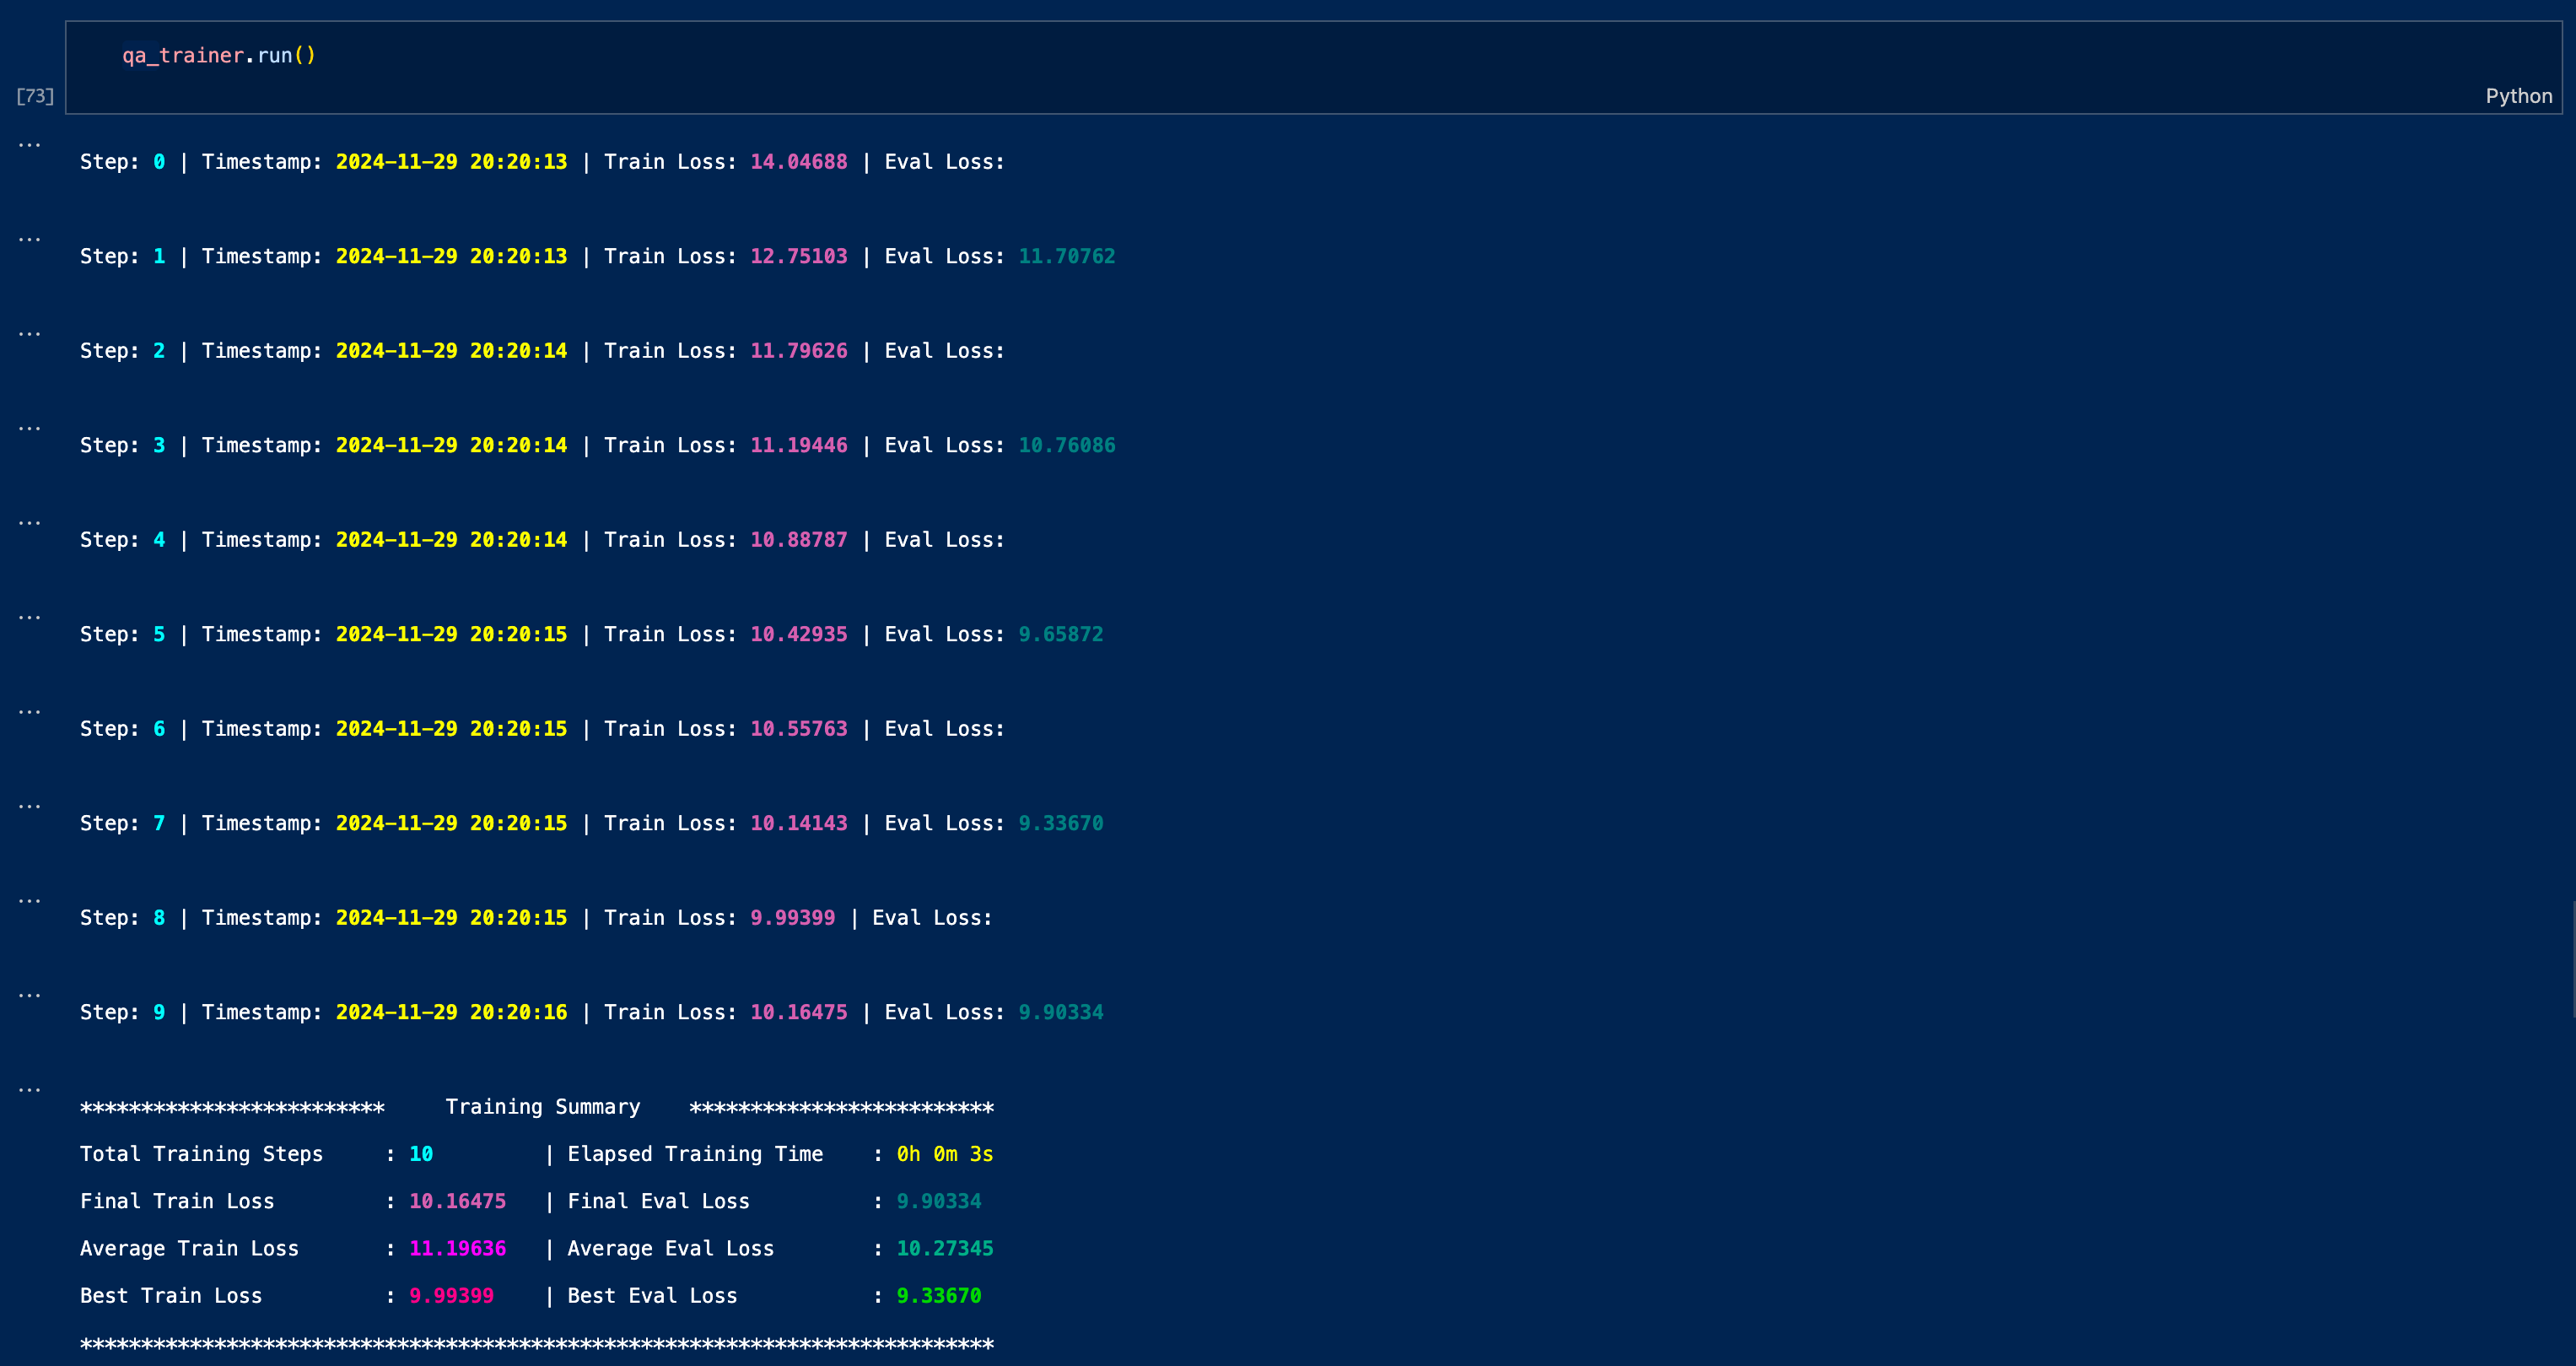

In [51]:
lora_qa_terminal_log_example_path = os.path.join(asset_dir, "lora_qa_terminal_log_example.png")
Image.open(lora_qa_terminal_log_example_path)

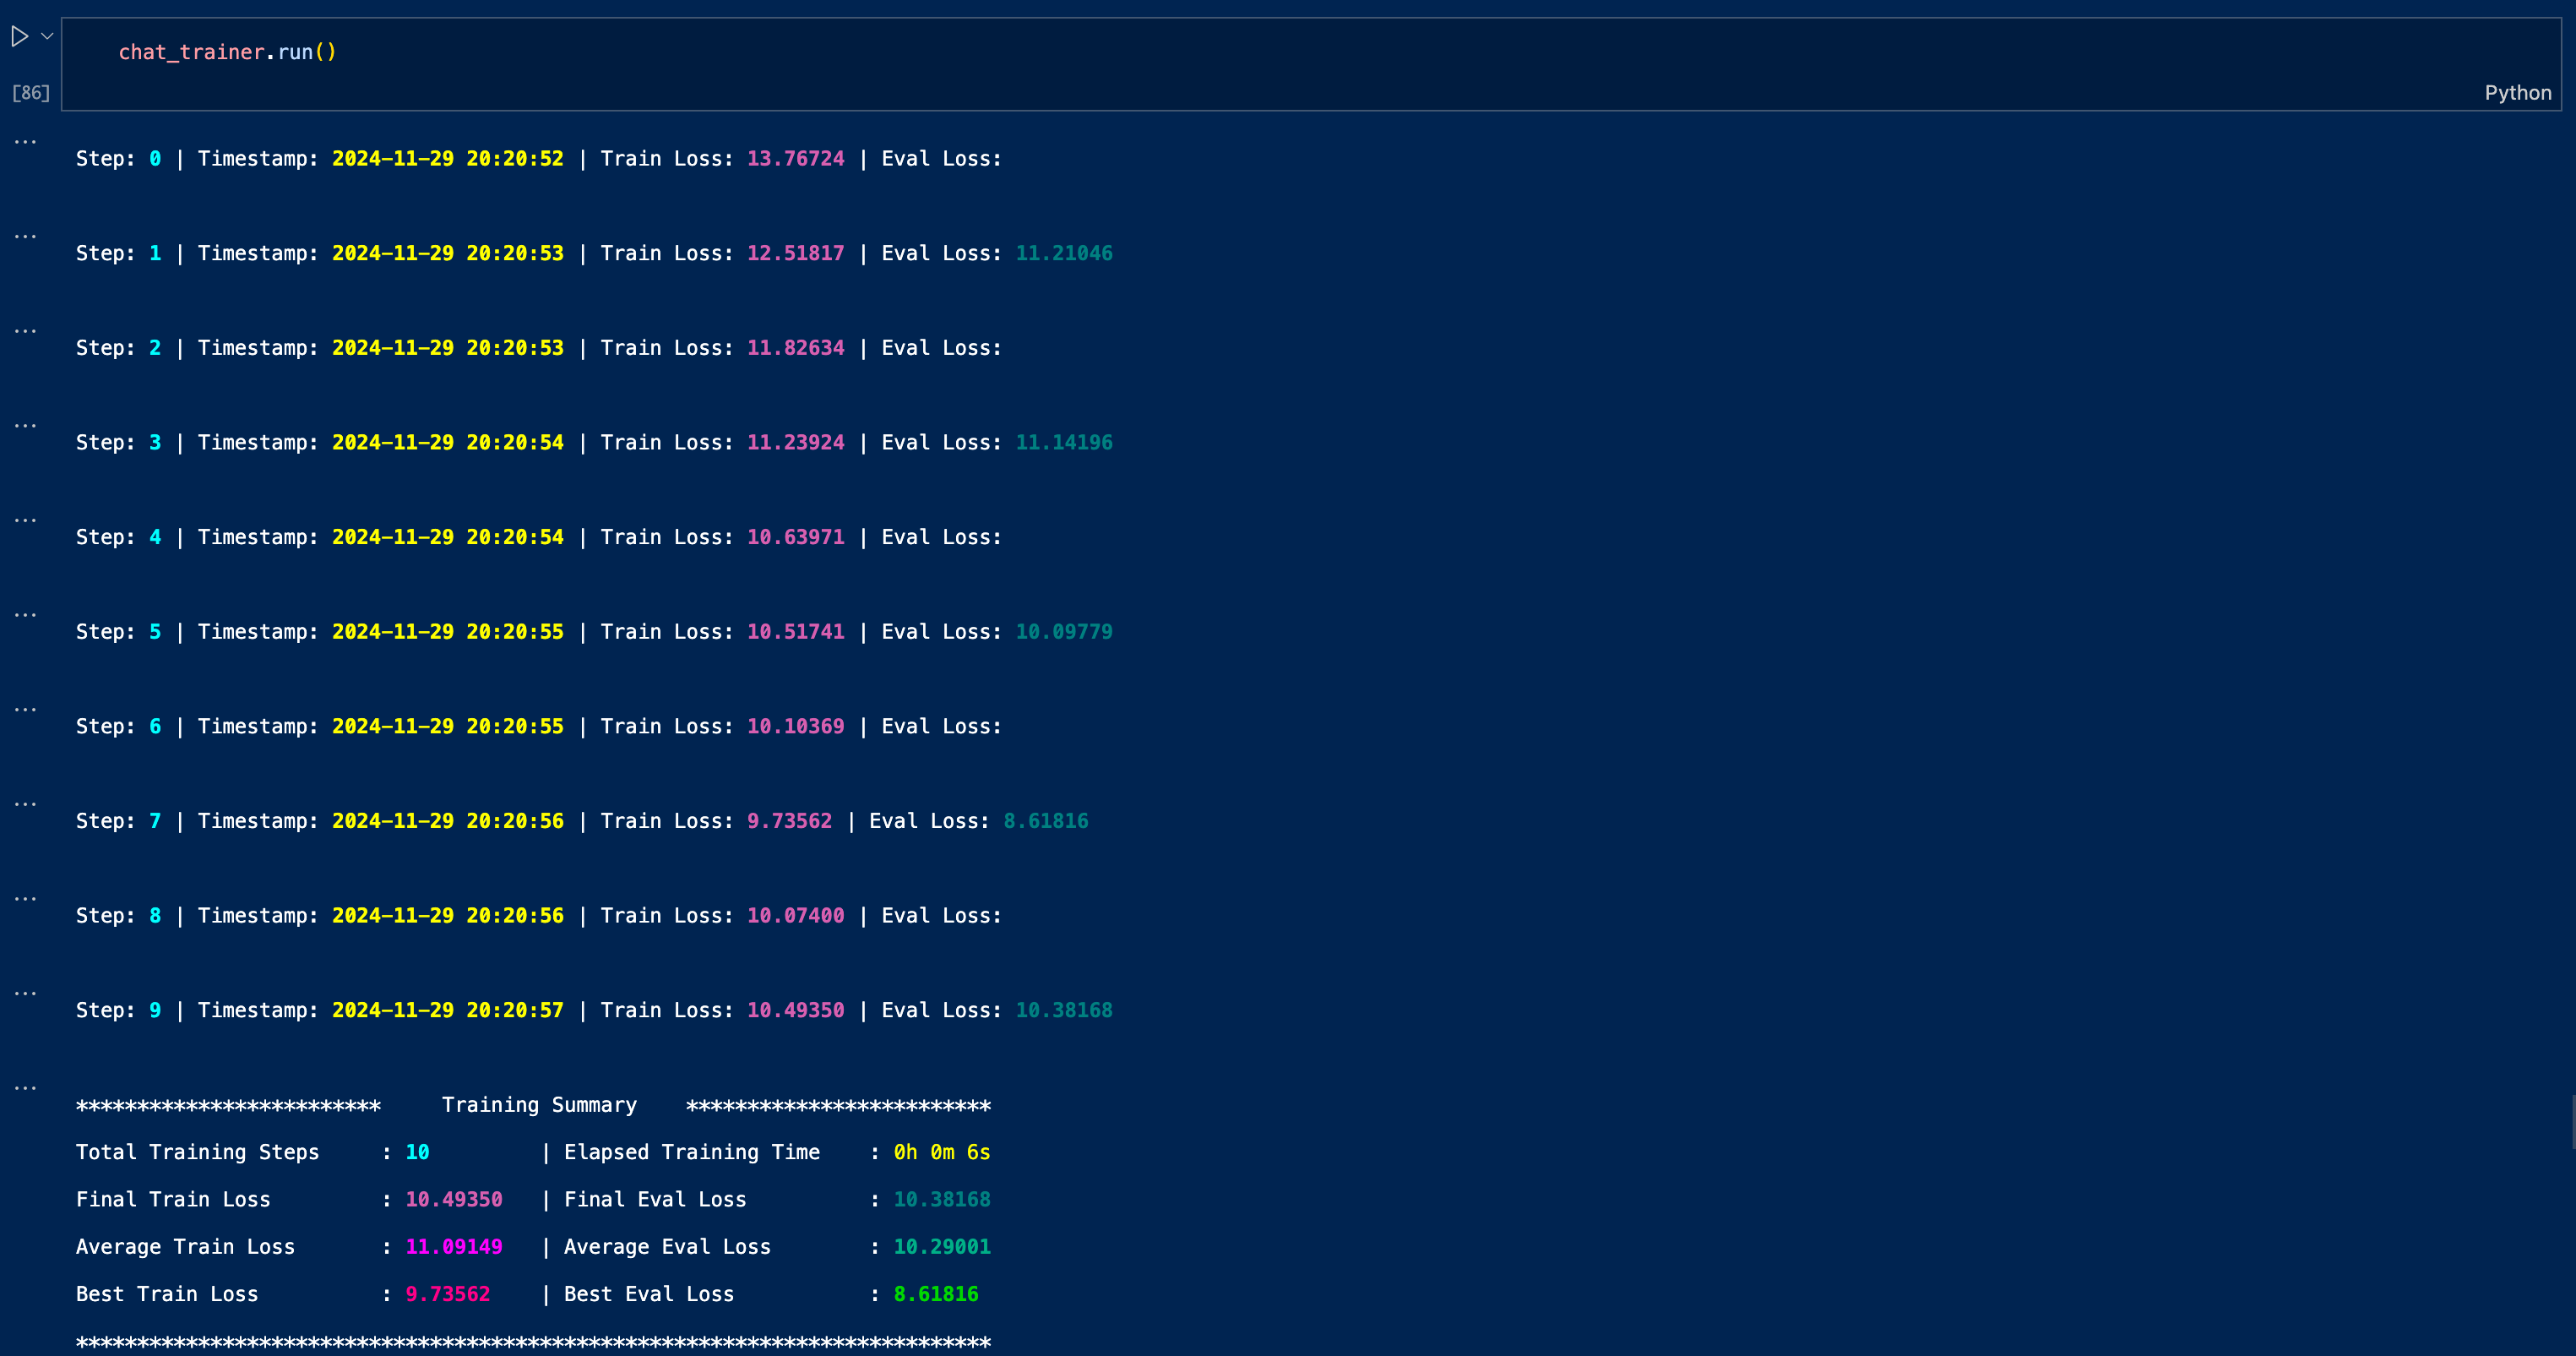

In [52]:
lora_chat_terminal_log_example_path = os.path.join(asset_dir, "lora_chat_terminal_log_example.png")
Image.open(lora_chat_terminal_log_example_path)

##### LogType.TENSORBOARD

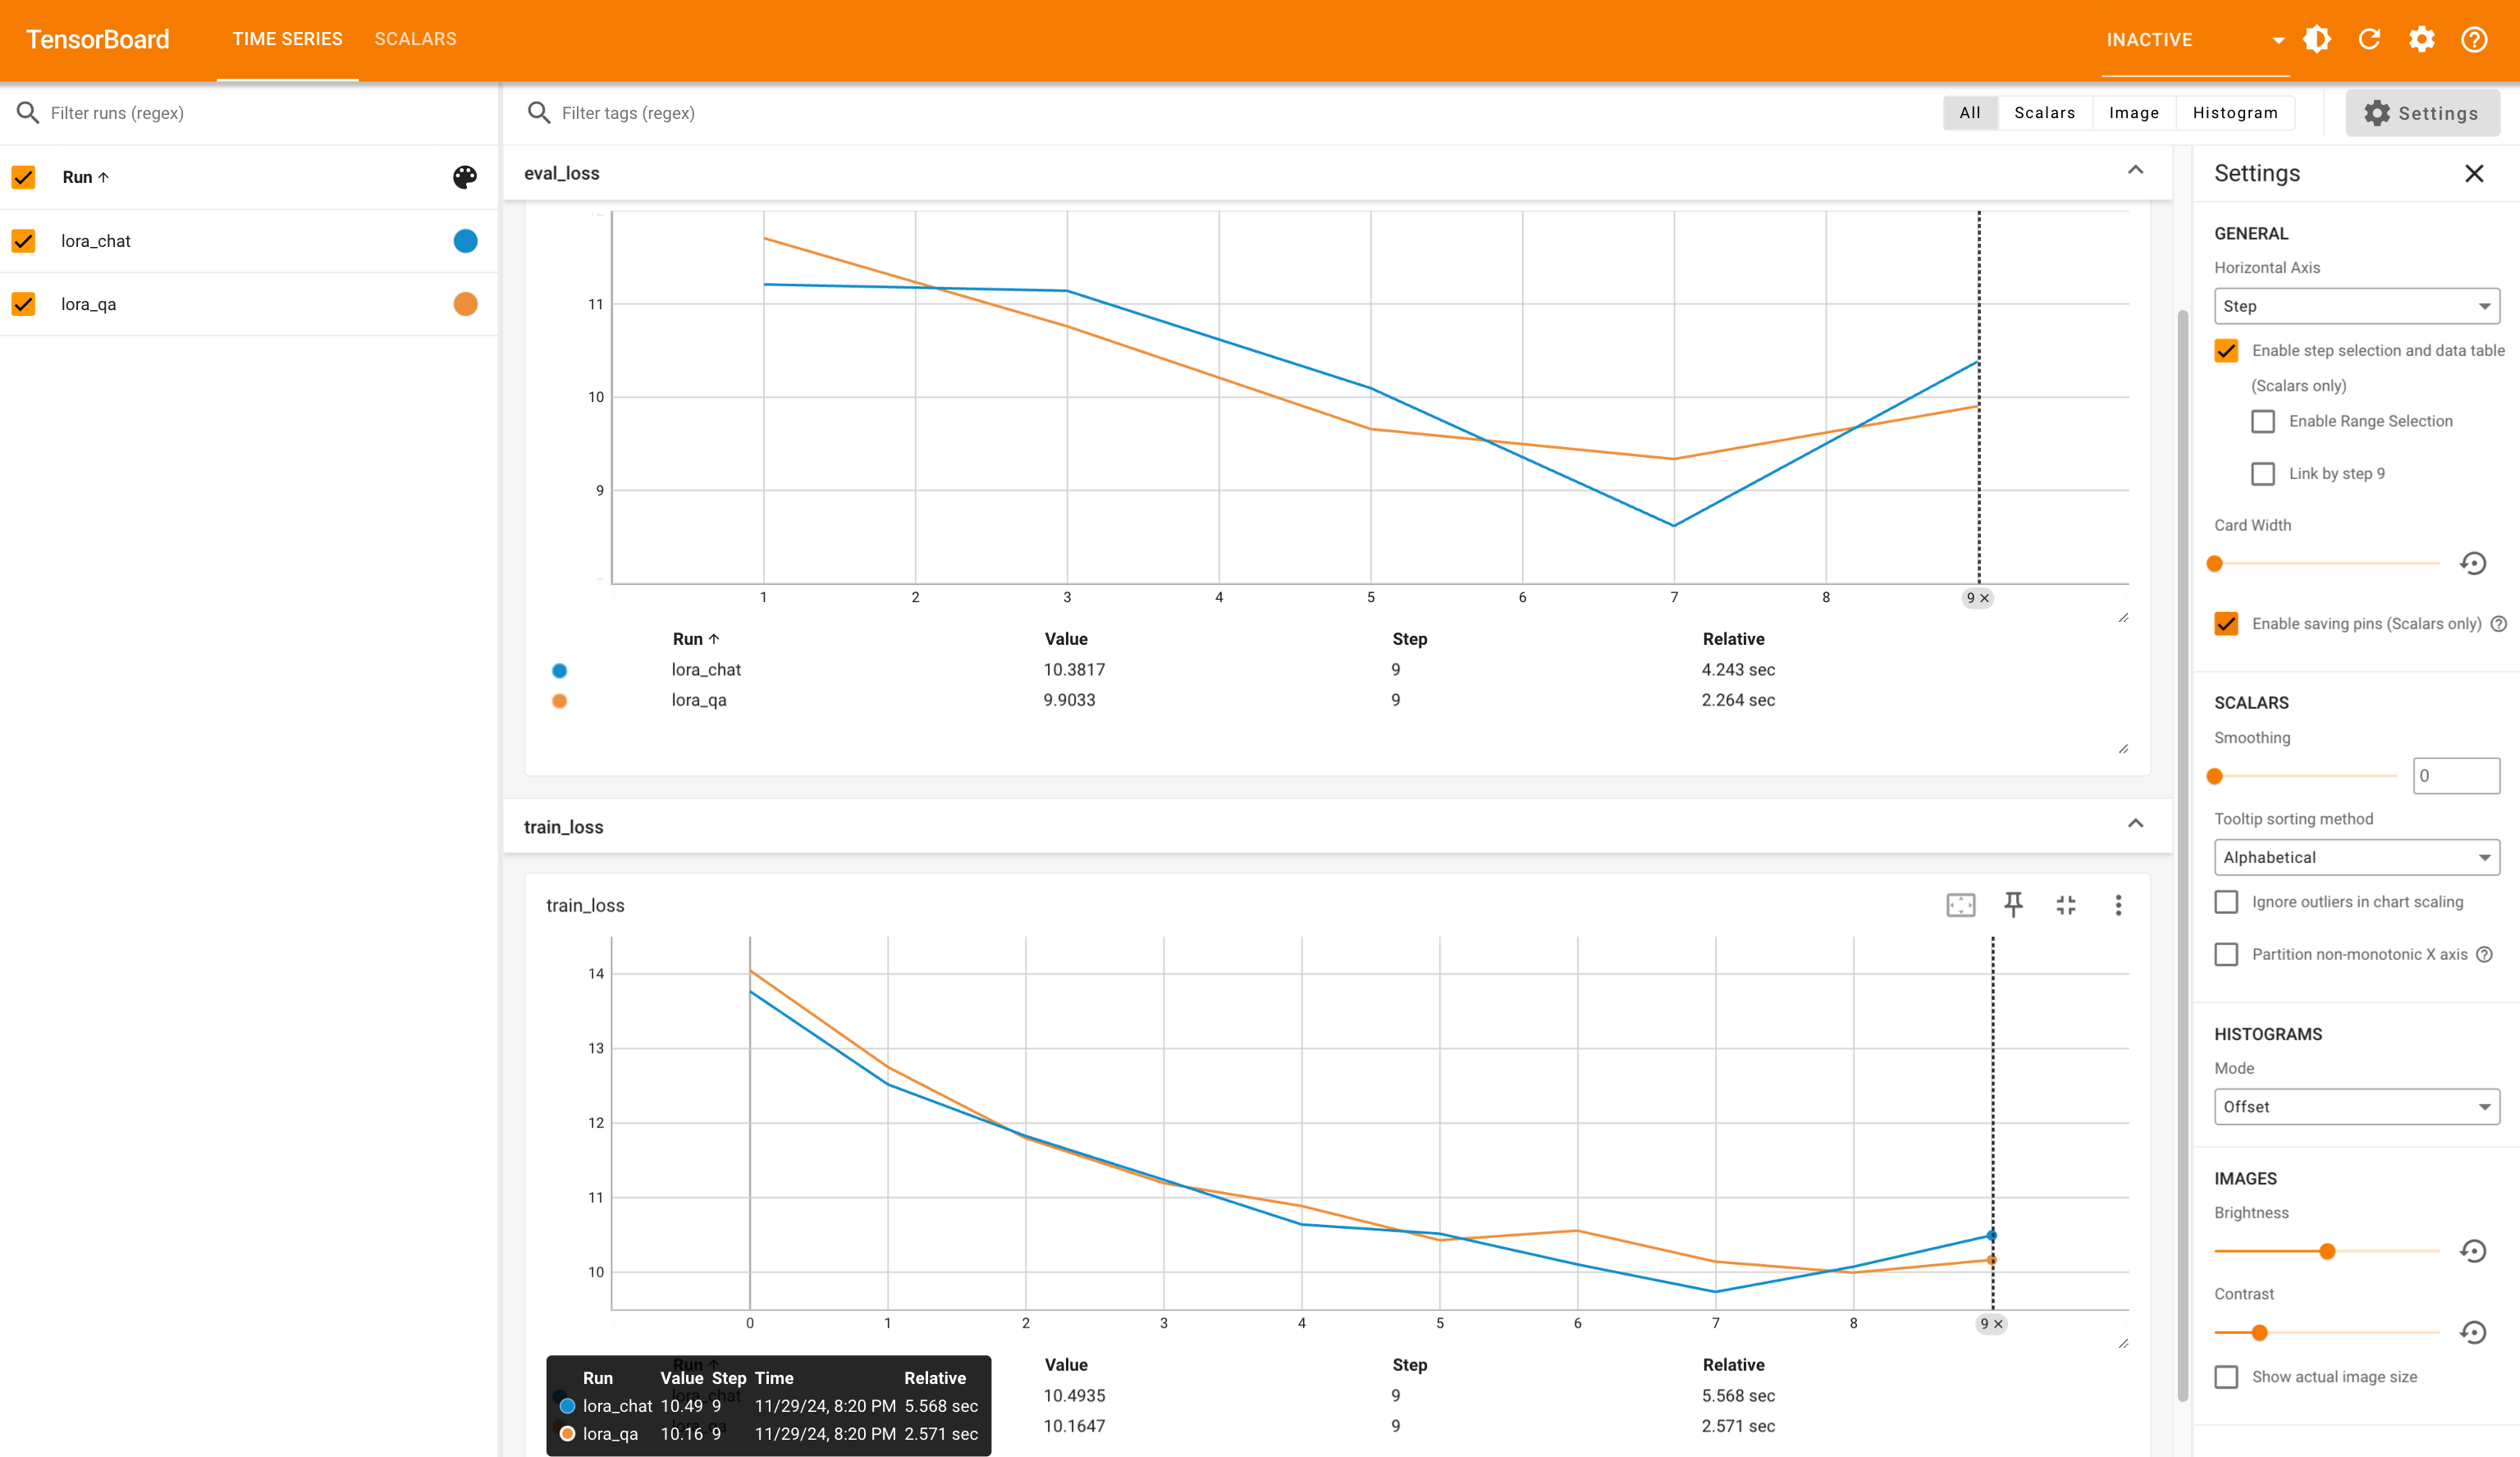

In [ ]:
lora_qa_chat_tensorboard_log_example_path = os.path.join(asset_dir, "lora_qa+chat_tensorboard_log_example.png")
Image.open(lora_qa_chat_tensorboard_log_example_path)

##### LogType.WANDB

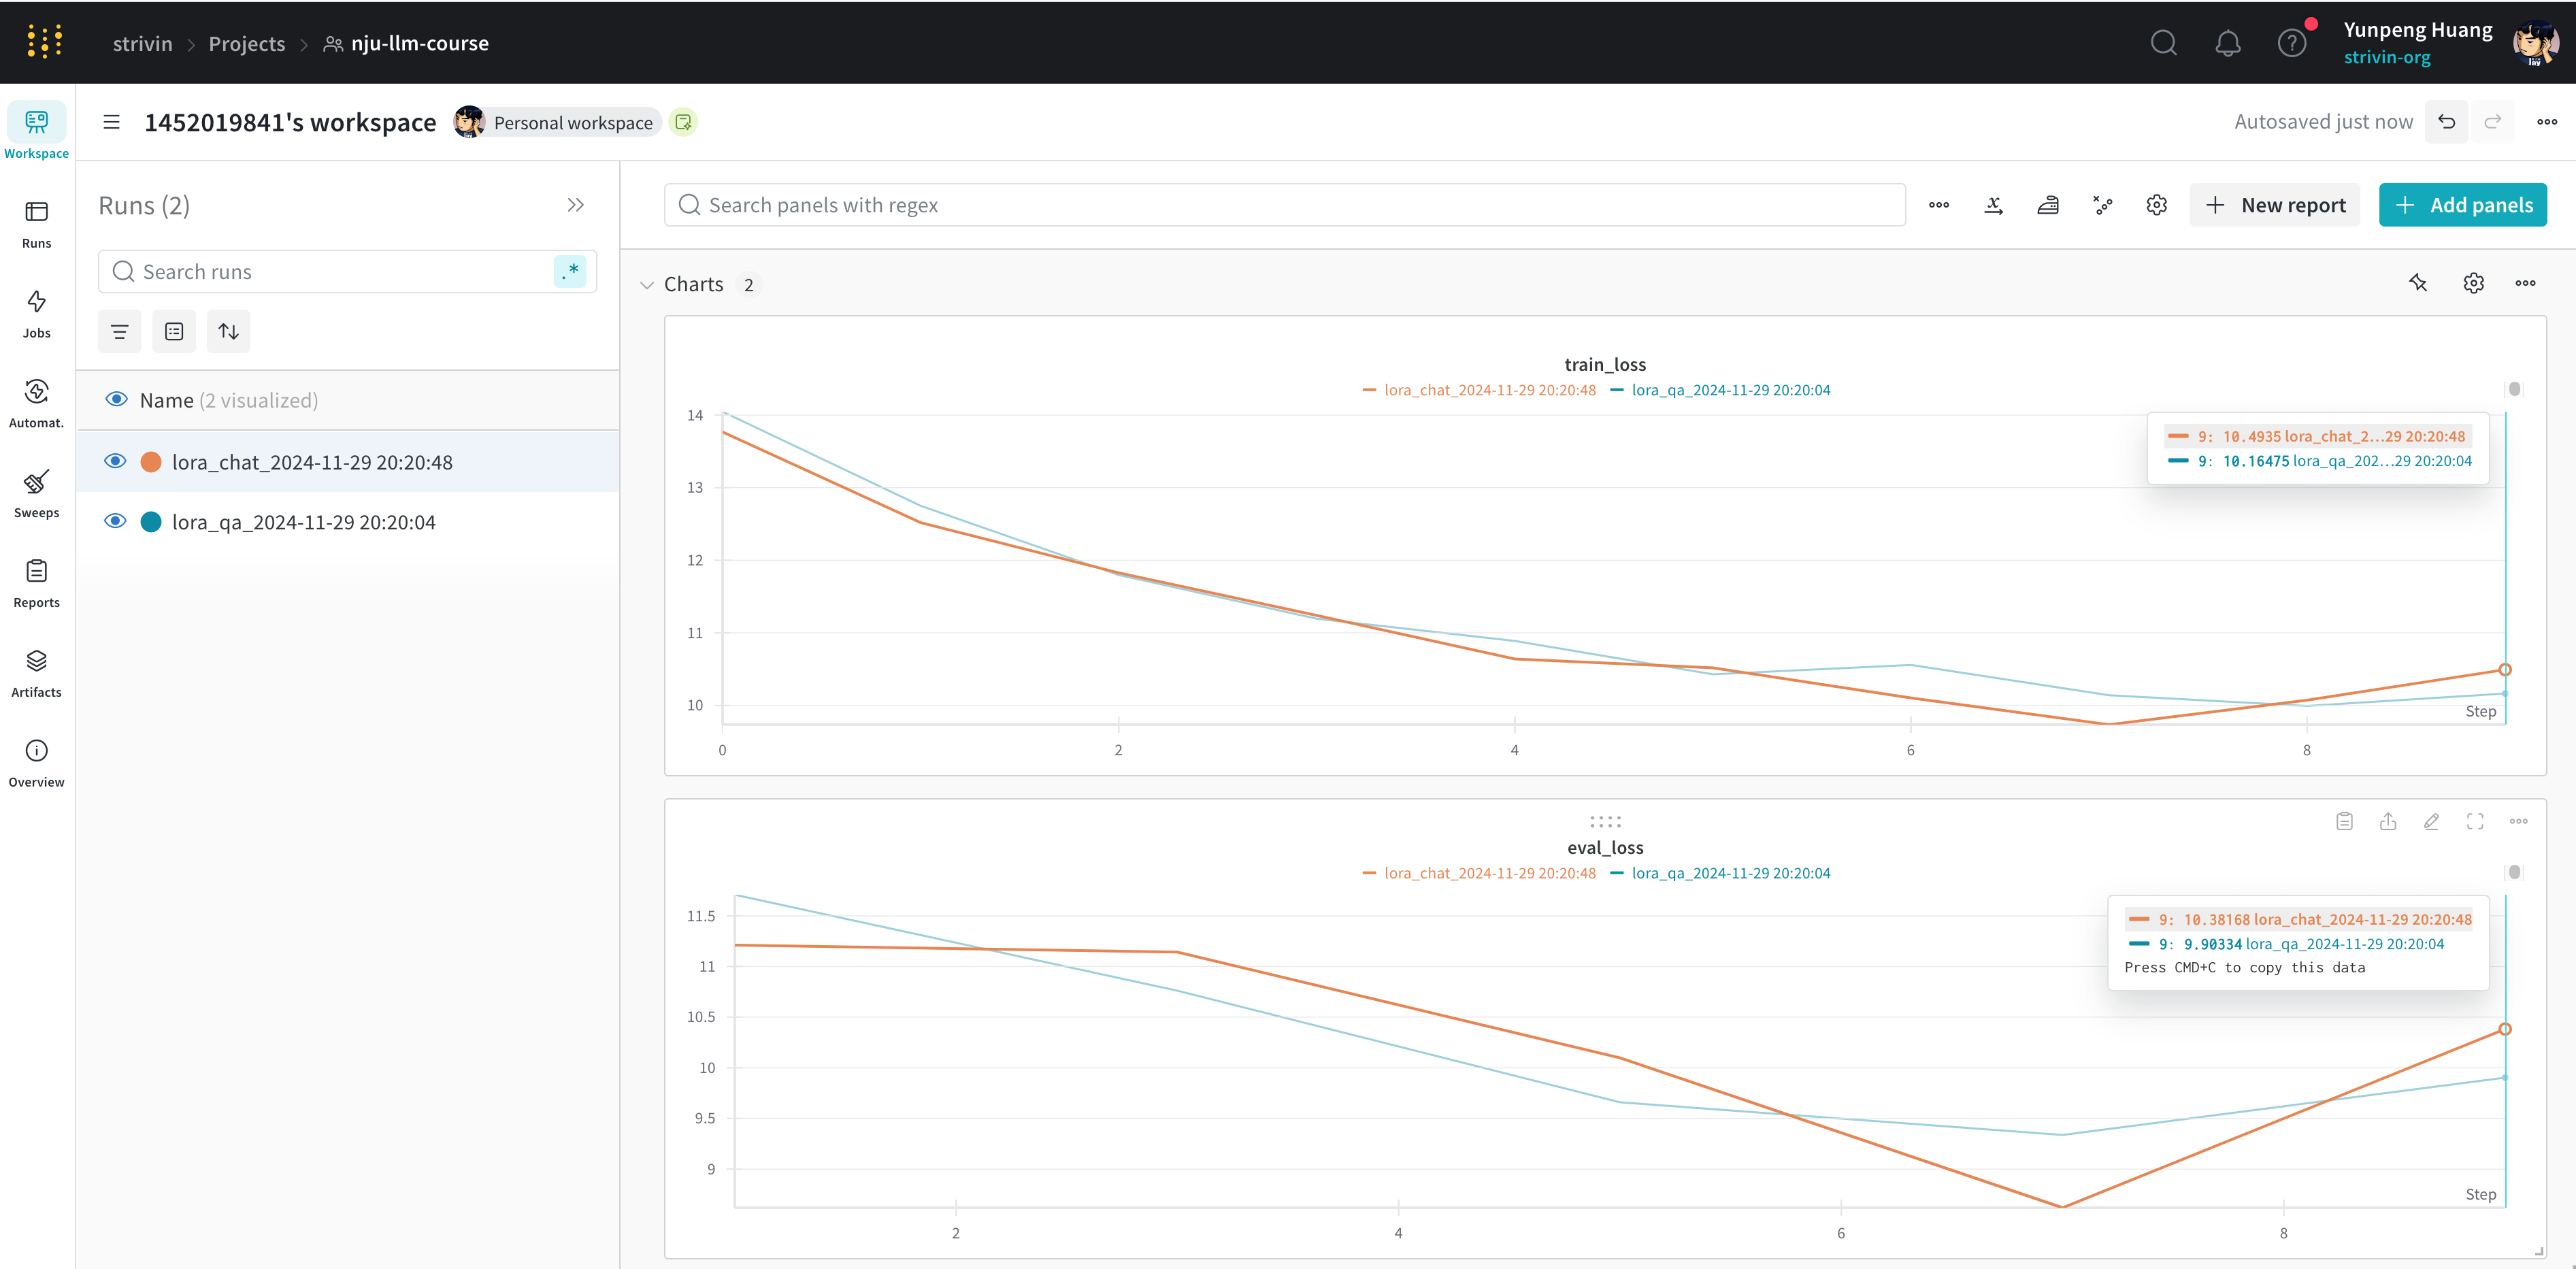

In [55]:
lora_qa_chat_wandb_log_example_path = os.path.join(asset_dir, "lora_qa+chat_wandb_log_example.png")
Image.open(lora_qa_chat_wandb_log_example_path)